In [5]:
% load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
%%R
library("phyloseq")
library(ggplot2)
library(dplyr)

In [7]:
%%R
physeq = import_biom("../../SeqData/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [8]:
%%R
physeq.buff <- subset_samples(physeq,Month==2.5|Month==3)
physeq.buff <- subset_samples(physeq.buff,Trtmt=="K"|Trtmt=="Q"|Trtmt=="F")
#Making physeq with only the PCR replicated data
physeq.buff

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 2200 taxa and 67 samples ]
sample_data() Sample Data:       [ 67 samples by 9 sample variables ]
tax_table()   Taxonomy Table:    [ 2200 taxa by 8 taxonomic ranks ]


In [9]:
%%R
ps <- physeq.buff

In [10]:
%%R
# Normalizes the sample counts by the total - i.e., reporting what fraction of each sample each OTU makes up.
ps_snorm = transform_sample_counts(ps, function(x) x / sum(x))

In [14]:
%%R
# Computing the Bray distance matrix and NMDS in parallel

ord.NMDS.full = ordinate(ps_snorm, method = "NMDS", distance = "bray", k=3)
NMDS.full = plot_ordination(ps_snorm, ord.NMDS.full, axes = c(1,2), justDF = TRUE)
NMDS.full$Samples = rownames(NMDS.full)

Run 0 stress 0.1338087 
Run 1 stress 0.1336365 
... New best solution
... procrustes: rmse 0.09264542  max resid 0.3481652 
Run 2 stress 0.1327632 
... New best solution
... procrustes: rmse 0.08911835  max resid 0.3338654 
Run 3 stress 0.1307832 
... New best solution
... procrustes: rmse 0.05482284  max resid 0.2589553 
Run 4 stress 0.1356007 
Run 5 stress 0.1329054 
Run 6 stress 0.132243 
Run 7 stress 0.1322519 
Run 8 stress 0.1356277 
Run 9 stress 0.1315739 
Run 10 stress 0.1352596 
Run 11 stress 0.1306695 
... New best solution
... procrustes: rmse 0.06821314  max resid 0.3645066 
Run 12 stress 0.1311544 
... procrustes: rmse 0.04565964  max resid 0.2574848 
Run 13 stress 0.1361773 
Run 14 stress 0.1300874 
... New best solution
... procrustes: rmse 0.04842811  max resid 0.2636223 
Run 15 stress 0.132651 
Run 16 stress 0.1308213 
Run 17 stress 0.1359178 
Run 18 stress 0.1355247 
Run 19 stress 0.133276 
Run 20 stress 0.1308075 


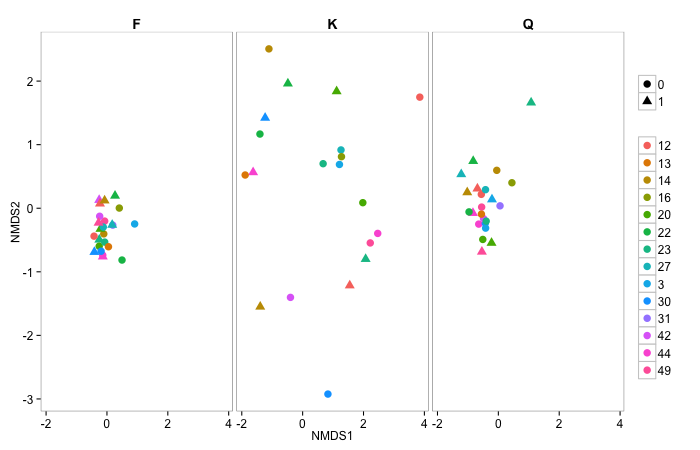

In [18]:
%%R -h 450 -w 700
D <- NMDS.full
# Sets the relevant ordination

#D$Trtmt <- as.factor(D$Trtmt)
#levels(D$Trtmt) <- c("Ferrihydrite", "Heavy Fraction", "Kaolinite", "Quartz", "Soil")

colnames(D)[1:2]<-c("NMDS1","NMDS2")
# Renames the axis columns

#D$AmdmtName = ifelse(D$Amdmt==1,"PyOM",ifelse(D$Amdmt==2,"Stover","Soil only"))
#D$AmdmtName = factor(D$AmdmtName, levels=c("Soil only", "PyOM", "Stover"))
#D$DayName = ifelse(D$Day==1,"Day 12",ifelse(D$Day==2,"Day 82","Day 1"))

# Creates an plot object, using the df.sites data, with the x and y axes specified as the PCoA axes,
p = ggplot(D, aes(x = NMDS1, y = NMDS2, color = Cosm, shape = Buff))

# Determines the size of the symbols
p = p  + geom_point(size=3.5)

p = p + guides(colour = guide_legend(""), shape = guide_legend(""))

# Determines the color theme of the plot overall
p = p + theme_bw() +
  theme(
    plot.background = element_blank()
   ,panel.grid.major = element_blank()
   ,panel.grid.minor = element_blank()
  ) +
  theme(strip.text.x = element_text(size=14, face="bold"),axis.text = element_text(size=12),legend.text = element_text(size=12),
          strip.background = element_rect(colour="white", fill="white"))

# Displays the plot object
p = p + facet_wrap(~Trtmt)
# The axis scales could be all optimized individually
# p = p + facet_grid(~Month)
# Adds a "facet_wrap" to it, which means it will plot it separately by whatever we specify - here, Days
#plot.full.byDay = p
p

Could afford to ignore buffer samples

In [19]:
%%R
sample.data<-data.frame(sample_data(physeq)) %>%
    dplyr::group_by(Trtmt,Month,Buff) %>%
    dplyr::summarize(total=n())
sample.data

Source: local data frame [20 x 4]
Groups: Trtmt, Month

   Trtmt Month Buff total
1      B                1
2      F     2    0     4
3      F   2.5    0     9
4      F   2.5    1     5
5      F     3    0     5
6      F     3    1     5
7      H   2.5    1     3
8      K     2    0     4
9      K   2.5    0     8
10     K   2.5    1     2
11     K     3    0     5
12     K     3    1     5
13     Q     2    0     5
14     Q   2.5    0     9
15     Q   2.5    1     4
16     Q     3    0     5
17     Q     3    1     5
18     S     2    0     5
19     S   2.5    0     6
20     S     3    0     5
